In [44]:
# url = "https://usaupload.com/72Eb/mnist.zip?download_token=975848d46b9b21c8c1e3f4c0bbbcf7c71331c143233d64e445bc7899244215fe"
# name = url.split("/")[-1]
# fileName = name.split("?")[0]

# !wget $url
# !mv $name $fileName

In [45]:
# %%capture
# !unzip mnist.zip;

## Start

In [46]:
import numpy as np
import random
import tensorflow as tf
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras import models, layers
from sklearn.metrics import accuracy_score
from keras import backend
import matplotlib.pyplot as plt

In [47]:
mySeed = 42
np.random.seed(mySeed)
random.seed(mySeed)
tf.random.set_seed(mySeed)
# torch.manual_seed(mySeed)

## Load Data

In [48]:
def load_mnist_bypath(lst_image_paths, verbose=-1):
    """ Expect to read images where each class is in a separate directory,
        For example: images of type 0 are in folder 0
    """

    lstData = list()
    lstLabel = list()

    for (i, imgPath) in enumerate(lst_image_paths):
        img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
        img = img.flatten()
        img = img/255

        label = imgPath.split(os.path.sep)[-2]

        lstData.append(img)
        lstLabel.append(label)

        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i+1) % verbose == 0:
            print(f"[INFO] processed {i+1}/{len(lst_image_paths)}")
            break

    return lstData, lstLabel

In [49]:
img_path = "../mnist/trainingSet/trainingSet"
# img_path = "/content/mnist/trainingSet/trainingSet"

# Generate a list of all images
lst_image_paths = list(paths.list_images(img_path))

lstData, lstLabel = load_mnist_bypath(lst_image_paths, verbose=10000)
data = np.array(lstData)
labels = np.array(lstLabel)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

oneHotEncoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
y_train = oneHotEncoder.fit_transform(y_train.reshape(-1, 1))
y_test = oneHotEncoder.transform(y_test.reshape(-1, 1))

print(f"Train x={x_train.shape}, y={y_train.shape}")
print(f"Test x={x_test.shape}, y={y_test.shape}")

[INFO] processed 10000/42000
Train x=(8000, 784), y=(8000, 3)
Test x=(2000, 784), y=(2000, 3)


## Training

In [50]:
def create_clients_with_data_assignment(image_list, label_list, num_clients=10, initial="client"):
    """ return: A dictionary with the customer id as the dictionary key and the value
                will be the data fragment - tuple of images and labels.
        args:
            image_list: a numpy array object with the images
            label_list: list of binarized labels (one-hot encoded)
            num_clients: number of customers (clients)
            initial: the prefix of the clients, e.g., client_1
     """

    # create list of client names
    client_names = [f"{initial}_{i+1}" for i in range(num_clients)]

    # shuffle the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    # shard the data and split it for each customer
    size = len(data) // num_clients
    shards = [data[i: i+size]  for i in range(0, size*num_clients, size)]

    # Check if the fragment number is equal to the number of clients
    assert(len(shards) == len(client_names))

    return {client_names[i]: shards[i]  for i in range(len(client_names))}

In [51]:
def batch_data(data_shard, batch_size=32):
    """ Receives a piece of data (imgs, labels) from a client and creates a tensorflow Dataset object in it
        args:
            data_shard: data and labels that make up a customer's data shard
            batch_size: batch size
        return:
            data tensorflow Dataset object
    """
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label), reshuffle_each_iteration=False).batch(batch_size)


### Explaining the function with example ###
# test = list(zip([[1, 2], [3, 4], [5, 6], [7, 8]], ["a", "b", "c", "d"]))
# print(test)
# data, label = zip(*test)
# print(data)
# print(label)

# dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
# test1 = dataset.shuffle(len(label))
# print(list(test1.as_numpy_iterator()))
# test2 = dataset.shuffle(len(label)).batch(3)
# print(list(test2.as_numpy_iterator()))
# list(test2)[0][0].shape

In [52]:
def scale_model_weights(weight, scalar):
    """ Scale the model weights """

    weight_final = []
    for i in range(len(weight)):
        weight_final.append(weight[i] * scalar)

    return weight_final

In [53]:
def test_local_model(client_data, client_name, model, loss_func, is_print=True):
    client_x, client_y = zip(*client_data)
    client_x = np.array(client_x)
    client_y = np.array(client_y)

    client_y_pred = model.predict(client_x, verbose=0)
    loss = loss_func(client_y, client_y_pred)

    # 'np.argmax(client_y_pred, axis=1)' Faster but get much more space
    acc = accuracy_score(tf.argmax(client_y, axis=1), tf.argmax(client_y_pred, axis=1))
    
    if is_print:
        print(f"{client_name} | local_acc: {acc:.4} | local_loss: {loss:.4}")

    return acc, loss.numpy()

In [54]:
def test_global_model(x_test, y_test, model, loss_func, comm_round, is_print=True):
    y_pred = model.predict(x_test)
    loss = loss_func(y_test, y_pred)

    acc = accuracy_score(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))

    if is_print:
        print(f"round: {comm_round} | global_acc: {acc:.4%} | global_loss: {loss:.4} \n")

    return acc, loss.numpy()

In [55]:
def sum_scaled_weights(scaled_weight_list):
    """ Return the sum of the listed scaled weights.
        axis_O is equivalent to the average weight of the weights """

    avg_weights = list()
    # get the average gradient accross all client gradients
    for gradient_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(gradient_list_tuple, axis=0)
        avg_weights.append(layer_mean)

    return avg_weights


### Explaining the function with example ###
# t = [[[[2, 3],[3, 4]], [[3, 4],[4, 5]], [[4, 5],[5, 6]]],
#      [[[5, 6],[6, 7]], [[6, 7],[7, 8]], [[7, 8],[8, 9]]]]
# for y in zip(*t):
#     print(y)
#     print(tf.math.reduce_sum(y, axis=0))

In [56]:
class MLP:
    @staticmethod
    def build(shape, classes):
        model = models.Sequential([
            layers.Dense(100, activation="relu", input_shape=shape),
            layers.Dense(100, activation="relu"),
            layers.Dense(classes, activation="softmax"),
            ])

        return model

In [57]:
# Hyper parameters

num_clients = 2
batch_size = 32
test_batch_size = len(y_test)

client_select_rate = 1

comms_round = 2
client_epochs = 1
lr = 0.01
# optimizer = optimizers.Adam(learning_rate=lr, decay=lr/comms_round)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr/comms_round)
# optimizer = "adam"
loss_cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = ["accuracy"]

In [58]:
# Create clients and batched data

clients = create_clients_with_data_assignment(x_train, y_train, num_clients=num_clients, initial="client")

# Bached data with tensorflow data object
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data, batch_size)

# Convert test data to tensorflow data object
test_batched = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(test_batch_size)

In [59]:
global_history = {"accuracy":list(), "loss":list()}
mlp_global = MLP()
global_model = mlp_global.build(x_train.shape[1:], y_train.shape[-1])

# Global training loop collection
for comm_round in range(comms_round):

    # global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()

    # randomize client - using keys
    client_names = list(clients_batched.keys())
    random.shuffle(client_names)
    client_select = client_names[0: int(num_clients*client_select_rate)]

    # calculate total training data across selected clients
    # if all clients have a same length
    global_count = len(clients[client_select[0]]) * len(client_select)

    # initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    # loop through each client and create a new local model
    for client in client_select:
        mlp_local = MLP()
        local_model = mlp_local.build(x_train.shape[1:], y_train.shape[-1])
        local_model.compile(optimizer=optimizer, loss=loss_cce, metrics=metrics)

        # set the weight of the local model from the weight of the global model
        local_model.set_weights(global_weights)

        # fit local model with client's data
        local_model.fit(clients_batched[client], epochs=client_epochs, verbose=0)

        # scale the model weights and added to the list
        local_count = len(clients[client])
        scaling_factor = local_count / global_count
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        # Print local accuracy
        test_local_model(clients[client], client, local_model, loss_cce)

        # clear session to free memory after each communication round
        backend.clear_session()


    # to get the average over all the local model, we simply take the sum of the scaled weights
    avg_weights = sum_scaled_weights(scaled_local_weight_list)

    # update global model
    global_model.set_weights(avg_weights)

    # test global model and print out metrics after each communications round
    for (x_test, y_test) in test_batched:
        global_acc, global_loss = test_global_model(x_test, y_test, global_model, loss_cce, comm_round+1)
        global_history["accuracy"].append(global_acc)
        global_history["loss"].append(global_loss)

client_1 | local_acc: 0.9885 | local_loss: 0.03527
client_2 | local_acc: 0.9965 | local_loss: 0.0114
63/63 [==============================] - 1s 13ms/step
round: 1 | global_acc: 98.9000% | global_loss: 0.05843 

client_2 | local_acc: 0.9945 | local_loss: 0.01702
client_1 | local_acc: 0.994 | local_loss: 0.02153
63/63 [==============================] - 1s 14ms/step
round: 2 | global_acc: 99.5000% | global_loss: 0.01714 



## Result

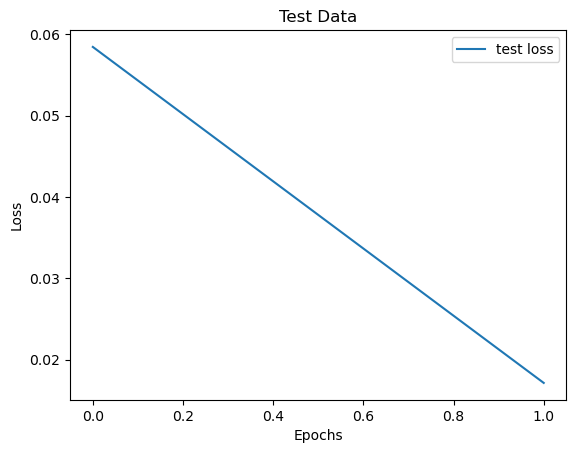

In [70]:
plt.plot(global_history["loss"], label="test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test Data")
plt.legend()
plt.show()

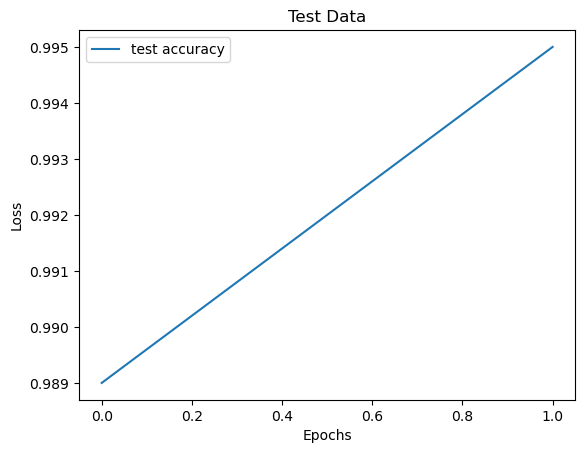

In [71]:
plt.plot(global_history["accuracy"], label="test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Data")
plt.legend()
plt.show()

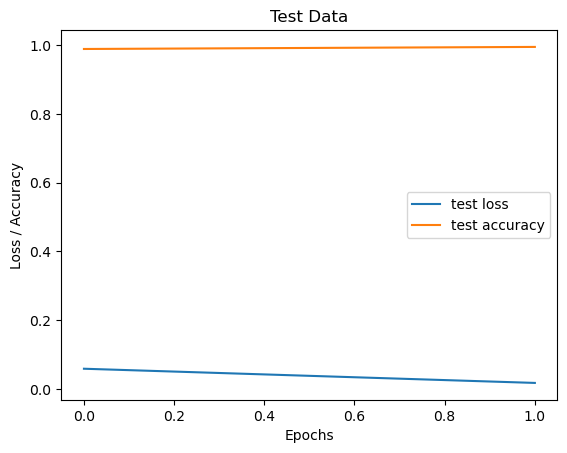

In [73]:
plt.plot(global_history["loss"], label="test loss")
plt.plot(global_history["accuracy"], label="test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.title("Test Data")
plt.legend()
plt.show()